In [1]:
# the goal in this notebook is to train a simple one-convo network on EMNIST
# on a GPU!!! --> kayyy GPU not supported on macs, oh well


# import libraries necessary for building the CNN
import numpy as np
import keras
from keras.layers import Input, Conv2D, Dense, Activation, Flatten, Dropout, MaxPooling2D
from keras.models import Model
from keras.datasets import mnist
import tensorflow as tf

Using TensorFlow backend.
/Users/chloeloughridge/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
# for plotting the model
# !pip install pydot
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [3]:
# for emnist loading function
from scipy.io import loadmat
import pickle

In [4]:
# important variables
num_classes = 47 # one for each of the digits from 0-9
batch_size = 128 #tunable number
epochs = 13 #tunable number

In [5]:
# define function for loading data from EMNIST
# from here: https://www.kaggle.com/marcose18/cnn-on-emnist-dataset

def load_data(mat_file_path, width=28, height=28, max_=None, verbose=True):
    def rotate(img):
        # Used to rotate images (for some reason they are transposed on read-in)
        flipped = np.fliplr(img)
        return np.rot90(flipped)

    def display(img, threshold=0.5):
        # Debugging only
        render = ''
        for row in img:
            for col in row:
                if col > threshold:
                    render += '@'
                else:
                    render += '.'
            render += '\n'
        return render

    mat = loadmat(mat_file_path)
    # Load convoluted list structure form loadmat
    mat = loadmat(mat_file_path)

    # Load char mapping
    mapping = {kv[0]: kv[1:][0] for kv in mat['dataset'][0][0][2]}
    pickle.dump(mapping, open('bin/mapping.p', 'wb'))

    # Load training data
    if max_ == None:
        max_ = len(mat['dataset'][0][0][0][0][0][0])
    training_images = mat['dataset'][0][0][0][0][0][0][:max_].reshape(
        max_, height, width, 1)
    training_labels = mat['dataset'][0][0][0][0][0][1][:max_]

    # Load testing data
    if max_ == None:
        max_ = len(mat['dataset'][0][0][1][0][0][0])
    else:
        max_ = int(max_ / 6)
    testing_images = mat['dataset'][0][0][1][0][0][0][:max_].reshape(
        max_, height, width, 1)
    testing_labels = mat['dataset'][0][0][1][0][0][1][:max_]

    # Reshape training data to be valid
    if verbose == True:
        _len = len(training_images)
    for i in range(len(training_images)):
        if verbose == True:
            print('%d/%d (%.2lf%%)' % (i + 1, _len, ((i + 1)/_len) * 100))
        training_images[i] = rotate(training_images[i])
    if verbose == True:
        print('')

    # Reshape testing data to be valid
    if verbose == True:
        _len = len(testing_images)
    for i in range(len(testing_images)):
        if verbose == True:
            print('%d/%d (%.2lf%%)' % (i + 1, _len, ((i + 1)/_len) * 100))
        testing_images[i] = rotate(testing_images[i])
    if verbose == True:
        print('')
    
    # Convert type to float32
    training_images = training_images.astype('float32')
    testing_images = testing_images.astype('float32')

    # Normalize to prevent issues with model
    training_images /= 255
    testing_images /= 255

    nb_classes = len(mapping)

    return ((training_images, training_labels), (testing_images, testing_labels), mapping, nb_classes)

In [6]:
# load the data from EMNIST 
(X_train, Y_train), (X_test, Y_test), _ , _ = load_data("EMNIST_data/matlab/emnist-balanced", verbose=False)

In [7]:
# convert Y labels into one-hot vectors 
Y_train = keras.utils.to_categorical(np.squeeze(Y_train), num_classes) 
Y_test = keras.utils.to_categorical(np.squeeze(Y_test), num_classes)

(28, 28, 1)


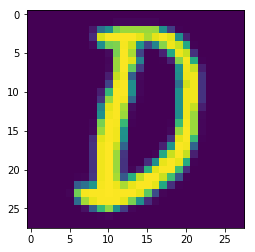

D


In [8]:
# visualize some of the input data
print(X_train[0].shape)
index = 13
plt.imshow(np.squeeze(X_train[index]))
plt.show()
print(chr((np.argmax((Y_train[index])) - 10) + 65))

In [19]:
# checking available devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6827585117203721415
]


In [23]:
# not so simple model

input_shape = [28,28,1]
X_input = Input(input_shape)

X = Conv2D(16, kernel_size=(3,3))(X_input)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(3,3), strides=2)(X)

X = Conv2D(32, kernel_size=(3,3))(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(3,3), strides=2)(X)

X = Conv2D(64, kernel_size=(2,2))(X)
X = Activation('relu')(X)
X = MaxPooling2D(pool_size=(3,3))(X)

X = Flatten()(X)
X = Dense(num_classes, activation='softmax')(X)

# instantiate model
model = Model(inputs=X_input, outputs=X)

In [24]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [25]:
# train the model on the new dataset
model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, Y_test))

Train on 112800 samples, validate on 18800 samples
Epoch 1/13
112800/112800 [==============================] - 52s 462us/step - loss: 1.3966 - acc: 0.5977 - val_loss: 0.7865 - val_acc: 0.7534
Epoch 2/13
112800/112800 [==============================] - 52s 464us/step - loss: 0.6236 - acc: 0.7975 - val_loss: 0.6192 - val_acc: 0.7993
Epoch 3/13
112800/112800 [==============================] - 56s 495us/step - loss: 0.5334 - acc: 0.8242 - val_loss: 0.5602 - val_acc: 0.8188
Epoch 4/13
112800/112800 [==============================] - 50s 447us/step - loss: 0.4853 - acc: 0.8383 - val_loss: 0.5532 - val_acc: 0.8216
Epoch 5/13
112800/112800 [==============================] - 59s 522us/step - loss: 0.4536 - acc: 0.8479 - val_loss: 0.5597 - val_acc: 0.8119
Epoch 6/13
112800/112800 [==============================] - 60s 528us/step - loss: 0.4315 - acc: 0.8536 - val_loss: 0.5697 - val_acc: 0.8190
Epoch 7/13
112800/112800 [==============================] - 54s 476us/step - loss: 0.4150 - acc: 0.8576

In [28]:
# evaluating the mnist model
model.evaluate(X_test, Y_test, batch_size=100)

18800/18800 [==============================] - 3s 170us/step


[0.4482486664931825, 0.8479787206396143]

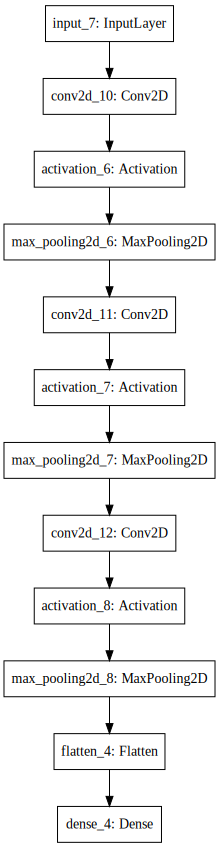

In [26]:
# visualizing model architecture
#import pydot
#plot_model(model, to_file='model01.png')
SVG(model_to_dot(model).create(prog='dot', format="svg"))

In [10]:
# going to visualize the filters of the model  . . . 
# inspiration from here: https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

# create a dictionary of the model's layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [12]:
from keras import backend as K #the backend in this case is tensorflow, since keras is sitting on top of it
                                #so importing the "backend" will allow us to write code in tensorflow that keras
                                #will be able to use for our model
        
#we'll be sending in an image the size of one of the MNIST images
img_width = 28
img_height = 28
        
layer_name = "conv2d_1"
filter_index = 31 #there are 32 filters, so this could be any number in the range 0-31

# create a loss function that we will use to maximize the activation of the specified layer
layer_output = layer_dict[layer_name].output # accesing the output of the specified layer stored in our dictionary
loss = K.mean(layer_output[:,:,:, filter_index]) # averaging all the outputs of the filter --> remember that the filter
                                                # is a 2-D "square" --> the middle two numbers represent height/width
                                                # of that square, the first number represents batch size, and the 
                                                # final number represents the number of filters (we're accessing a
                                                # specific one here)
# compute the gradient of the input picture with respect to this loss.
# this means we'll be updating the pixels of the input image, not the weights of the network --> clever!
grads = K.gradients(loss, model.input)[0] # I don't know what the [0] means at the end of this line
print(grads)

# normalizing the gradient --> we don't want the magnitude of our gradient ascent/descent step to be infuenced heavily 
# by the gradient --> the gradient gives us the direction we want to take --> so normalizing helps the optimization
# algorithm perform better
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads]) # this is a fancy way of writing a custom function that takes
                                                # an input image as an input, and returns the loss and gradients
                                                # for that image


Tensor("gradients/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 28, 28, 1), dtype=float32)


In [13]:
# running gradient ascent to maximize the activations of the filter

# generating a grey test image
input_img = np.random.random((1, img_width, img_height, 1)) * 20 + 128.

# Choosing an arbitrary value for "step" --> pretty sure this is like the learning rate
step = 5

# 20 steps of gradient ascent
for i in range(50):
    loss_value, grads_value = iterate([input_img])
    input_img += grads_value * step


In [14]:
# creating a function to deprocess the image 
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to black/white representation
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


(1, 28, 28, 1)


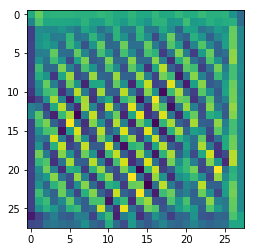

In [15]:
# saving the image as a file
img = input_img
img = deprocess_image(img)

# the imsave approach
#imsave('%s_filter_%d.png' % (layer_name, filter_index), img)
print(img.shape)


# the matplotlib approach
import matplotlib.pyplot as plt
plt.imshow(img.squeeze())
plt.show()

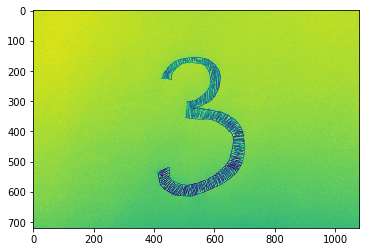

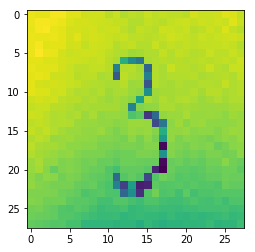

In [18]:
# upload the custom image and have the network make a prediction on it

# require students to take square images --> for scaling purposes

import cv2

# load the image in greyscale mode
my_img = cv2.imread("./my_img.jpg", 0)
plt.imshow(my_img)
plt.show()

# reshape the custom image
my_img = cv2.resize(my_img, (28,28))
plt.imshow(my_img)
plt.show()


In [19]:
# feed this image into the network for prediction purposes 
# add a new axis to represent the color channels, and another to indicate batch size
# also, the network will output a vector, but our final prediction is the index of the largest element in that vector,
# hence the argmax function
prediction = np.argmax(model.predict(my_img[np.newaxis, :,:, np.newaxis]))
print(prediction)

3


In [20]:
# demonstration purposes

dem = keras.utils.to_categorical(3, 10)
print(dem)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [16]:
model.evaluate(X_test, Y_test, batch_size=10)

10000/10000 [==============================] - 8s 835us/step


[0.03066047459807487, 0.9901999981999398]